Here we train a linear neural network. During the training it is evaluated every 100 batches to measure the effect increasing data has on its performance. It is trained only one epoch.

In [5]:
from context import speechact
import speechact.classifier.embedding as emb
import speechact.classifier.base as b
import speechact.evaluation as evaluation
import speechact.corpus as corp
import speechact.annotate as anno
import matplotlib.pyplot as plt


labels = [act.value for act in emb.SPEECH_ACTS]

# Load upsampled data. Note: the file names are correct even if it does not look like it.
test_corpus = corp.Corpus('../data/annotated data/dev-set-sentiment-train-upsampled.conllu.bz2')
dev_corpus = corp.Corpus('../data/annotated data/dev-set-sentiment-test-upsampled.conllu.bz2')
train_corpus = corp.Corpus('../data/auto-annotated data/speech-acts.conllu.bz2')




def plot_loss_histories(loss_history: list[float], dev_loss_history: list[float]):
    epochs = range(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, label='Training Loss')
    plt.plot(epochs, dev_loss_history, label='Dev Loss')
    plt.title('Training and Dev Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy_history(history: evaluation.TrainAccuracyHistory):
    plt.plot(history.data_amount, history.accuracies, label='Training Loss')
    plt.title('Accuracy on Dev Data')
    plt.xlabel('Batches')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)
    plt.show()


def train_model(corpus: corp.Corpus, 
                dev_corpus: corp.Corpus, 
                model_name: str,
                network_factory: emb.NetworkFactory|None = None,
                epochs = 10):
    
    print('Load classifier')
    classifier = emb.EmbeddingClassifier(network_factory=network_factory)

    print('Load dataset')
    dataset = emb.CorpusDataset(corpus)
    dev_dataset = emb.CorpusDataset(dev_corpus)

    batch_size = 32

    loss_history = []
    dev_loss_history = []
    accuracy_history = evaluation.TrainAccuracyHistory(dev_corpus, classifier, batch_size)
    
    print(f'Train classifier: {model_name}')
    classifier.train(dataset, 
                     batch_size, 
                     loss_history=loss_history, 
                     dev_loss_history=dev_loss_history,
                     dev_data=dev_dataset,
                     num_epochs=epochs,
                     batch_callback=accuracy_history.compute_accuracy,
                     callback_each_batch=100,
                     use_class_weights=True)
    classifier.save(model_name)

    plot_loss_histories(loss_history, dev_loss_history)
    plot_accuracy_history(accuracy_history)
    



def evaluate_model(corpus: corp.Corpus, 
                   model_name: str,
                   network_factory: emb.NetworkFactory|None = None):
    
    print('Load classifier')
    classifier = emb.EmbeddingClassifier(network_factory=network_factory)
    classifier.load(model_name)

    print(f'Evaluate classifier: {model_name}')
    return evaluation.evaluate(
        corpus,
        classifier,
        labels,
        draw_conf_matrix=True
    )

Load classifier
Load dataset
Train classifier: ../models/neural/no-hidden/final-model-1-epoch.pth


Training: epoch 1/1", unit="batch: 100%|██████████| 102932/102932 [24:36:42<00:00,  1.16it/s]   


Epoch 1/1, Loss: 0.7533615634588853


Eval on dev data: epoch 1/1", unit="batch: 100%|██████████| 137/137 [00:39<00:00,  3.50it/s]

Epoch 1/1, Dev loss: 0.5412956519718588
Training complete
Saving model to "../models/neural/no-hidden/final-model-1-epoch.pth"


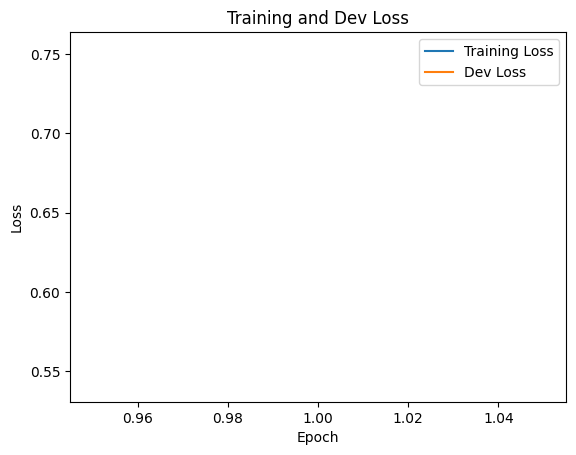

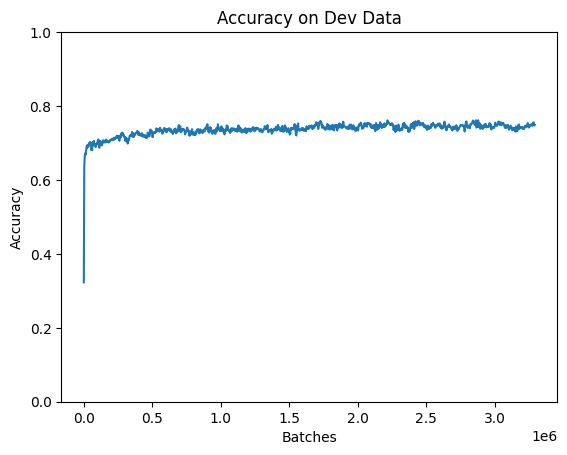

Load classifier
Loading model from "../models/neural/no-hidden/final-model-1-epoch.pth"
Evaluate classifier: ../models/neural/no-hidden/final-model-1-epoch.pth
Accuracy: 0.7506887052341598
Classification report:
              precision    recall  f1-score   support

   assertion       0.62      0.68      0.65      1089
    question       0.95      0.92      0.93      1089
   directive       0.72      0.80      0.76      1089
  expressive       0.73      0.60      0.66      1089

    accuracy                           0.75      4356
   macro avg       0.76      0.75      0.75      4356
weighted avg       0.76      0.75      0.75      4356

Confusion matrix:
            assertion  question  directive  expressive
assertion         742        30        153         164
question           34       998         20          37
directive         165        10        873          41
expressive        265         8        159         657


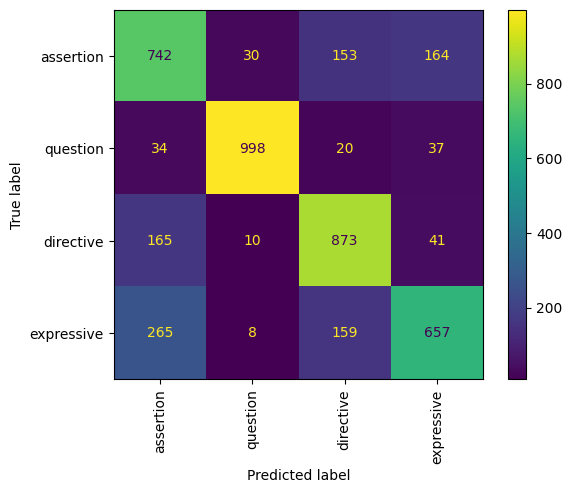

In [6]:

model_name = '../models/neural/no-hidden/final-model-1-epoch.pth'

train_model(train_corpus, 
            test_corpus, 
            model_name=model_name,
            epochs=1)
results = evaluate_model(test_corpus, model_name=model_name)